In [ ]:
import tensorflow as tf
from keras import layers
import gymnasium as gym
from gymnasium.wrappers import FrameStackObservation, AtariPreprocessing
import numpy as np
import os
import ale_py

# Performance and GPU Configuration
tf.config.optimizer.set_jit(True)
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

class ReplayBuffer:
    def __init__(self, max_size, state_shape, num_actions):
        self.max_size = max_size
        self.states = np.zeros((max_size, *state_shape), dtype=np.float32)
        self.actions = np.zeros(max_size, dtype=np.int32)
        self.rewards = np.zeros(max_size, dtype=np.float32)
        self.next_states = np.zeros((max_size, *state_shape), dtype=np.float32)
        self.dones = np.zeros(max_size, dtype=np.float32)
        self.index = 0
        self.is_full = False

    def add(self, state, action, reward, next_state, done):
        idx = self.index % self.max_size
        self.states[idx] = state
        self.actions[idx] = action
        self.rewards[idx] = reward
        self.next_states[idx] = next_state
        self.dones[idx] = done
        self.index += 1
        if self.index >= self.max_size:
            self.is_full = True

    def sample(self, batch_size):
        max_index = self.max_size if self.is_full else self.index
        indices = np.random.choice(max_index, batch_size, replace=False)
        return (
            self.states[indices],
            self.actions[indices],
            self.rewards[indices],
            self.next_states[indices],
            self.dones[indices]
        )
    def __len__(self):
        return self.max_size if self.is_full else self.index

class DQNAgent:
    def __init__(self, state_shape, num_actions, learning_rate=0.00025):
        self.state_shape = state_shape
        self.num_actions = num_actions
        self.model = self.create_q_model(state_shape, num_actions)
        self.target_model = self.create_q_model(state_shape, num_actions)
        self.target_model.set_weights(self.model.get_weights())
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, clipnorm=1.0)
        self.replay_buffer = ReplayBuffer(max_size=100000, state_shape=state_shape, num_actions=num_actions)
        self.gamma = 0.99
        self.epsilon = 1.0
        self.epsilon_min = 0.1
        self.epsilon_max = 1.0
        self.epsilon_random_frames = 50000
        self.epsilon_greedy_frames = 1000000.0  # Number of frames for exploration

    def create_q_model(self, input_shape, num_actions):
        return tf.keras.Sequential([
            layers.Input(shape=input_shape),
            layers.Conv2D(32, kernel_size=8, strides=4, activation="relu", kernel_initializer='he_uniform'),
            layers.Conv2D(64, kernel_size=4, strides=2, activation="relu", kernel_initializer='he_uniform'),
            layers.Conv2D(64, kernel_size=3, strides=1, activation="relu", kernel_initializer='he_uniform'),
            layers.Flatten(),
            layers.Dense(512, activation="relu", kernel_initializer='he_uniform'),
            layers.Dense(num_actions, activation="linear")
        ])

    def get_action(self, state):
        if np.random.rand() <= self.epsilon:
            return np.random.randint(self.num_actions)
        state_tensor = tf.convert_to_tensor(state[np.newaxis, ...], dtype=tf.float32)
        q_values = self.model(state_tensor, training=False)
        return tf.argmax(q_values[0]).numpy()

    @tf.function
    def train_step(self, states, actions, rewards, next_states, dones):
        future_rewards = self.target_model(next_states, training=False)
        target_q_values = rewards + self.gamma * tf.reduce_max(future_rewards, axis=1) * (1 - dones)
        with tf.GradientTape() as tape:
            q_values = self.model(states, training=True)
            q_action = tf.reduce_sum(tf.one_hot(actions, self.num_actions) * q_values, axis=1)
            loss = tf.keras.losses.Huber()(target_q_values, q_action)
        grads = tape.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))
        return loss

    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())

def main():
    # Paths for saving
    model_dir = "./models"
    log_file_path = "./logs/training_log.txt"

    os.makedirs(model_dir, exist_ok=True)

    # Environment setup
    gym.register_envs(ale_py)
    env = gym.make("SpaceInvadersNoFrameskip-v4", render_mode="rgb_array")
    env = AtariPreprocessing(env, frame_skip=4, grayscale_obs=True, scale_obs=True)
    env = FrameStackObservation(env, stack_size=4)

    # Agent setup
    state_shape = (84, 84, 4)
    num_actions = env.action_space.n
    agent = DQNAgent(state_shape, num_actions)

    # Training parameters
    max_episodes = 5000
    max_steps_per_episode = 10000
    update_target_every = 1000
    log_every = 1  # Log every episode
    episode_rewards = []
    frame_count = 0
    best_avg_reward = -float('inf')  # Track best average reward

    # Open a file for logging results
    with open(log_file_path, "w") as f:
        f.write("Episode,Avg_Reward,Epsilon\n")  # Write headers

    # Training loop
    for episode in range(max_episodes):
        state, _ = env.reset()
        state = np.array(state, dtype=np.float32) / 255.0
        state = np.transpose(state, (1, 2, 0))
        episode_reward = 0

        for step in range(max_steps_per_episode):
            frame_count += 1

            # Choose action
            if frame_count < agent.epsilon_random_frames:
                action = np.random.randint(num_actions)
            else:
                action = agent.get_action(state)

            # Step environment
            next_state, reward, done, _, _ = env.step(action)
            next_state = np.array(next_state, dtype=np.float32) / 255.0
            next_state = np.transpose(next_state, (1, 2, 0))

            # Store in replay buffer
            agent.replay_buffer.add(state, action, reward, next_state, done)
            state = next_state
            episode_reward += reward

            # Train only if enough samples in replay buffer
            if len(agent.replay_buffer) >= 32:
                states, actions, rewards, next_states, dones = agent.replay_buffer.sample(32)
                agent.train_step(states, actions, rewards, next_states, dones)

            # Decay epsilon
            if frame_count >= agent.epsilon_random_frames:
                agent.epsilon -= (agent.epsilon_max - agent.epsilon_min) / agent.epsilon_greedy_frames
                agent.epsilon = max(agent.epsilon_min, agent.epsilon)

            # Update target model
            if frame_count % update_target_every == 0:
                agent.update_target_model()

            if done:
                break

        episode_rewards.append(episode_reward)
        avg_reward = np.mean(episode_rewards[-log_every:])
        with open(log_file_path, "a") as f:
            f.write(f"{episode + 1},{avg_reward:.2f},{agent.epsilon:.4f}\n")
        print(f"Episode {episode + 1}, Avg Reward: {avg_reward:.2f}, Epsilon: {agent.epsilon:.4f}")

        # Save model conditionally
        if (episode + 1) % 100 == 0 or avg_reward > best_avg_reward:
            if avg_reward > best_avg_reward:
                best_avg_reward = avg_reward
                print(f"New best average reward: {best_avg_reward:.2f}. Saving best model.")
            agent.model.save(f"{model_dir}/episode{episode + 1}_space_invaders_model.keras")

    # Save final model
    agent.model.save(f"{model_dir}/final_space_invaders_model.keras")

if __name__ == "__main__":
    main()

# Continue train when stopped

In [ ]:
import tensorflow as tf
from keras import layers
import gymnasium as gym
from gymnasium.wrappers import FrameStackObservation, AtariPreprocessing
import numpy as np
import os
import ale_py

# Performance and GPU Configuration
tf.config.optimizer.set_jit(True)
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

class ReplayBuffer:
    def __init__(self, max_size, state_shape, num_actions):
        self.max_size = max_size
        self.states = np.zeros((max_size, *state_shape), dtype=np.float32)
        self.actions = np.zeros(max_size, dtype=np.int32)
        self.rewards = np.zeros(max_size, dtype=np.float32)
        self.next_states = np.zeros((max_size, *state_shape), dtype=np.float32)
        self.dones = np.zeros(max_size, dtype=np.float32)
        self.index = 0
        self.is_full = False

    def add(self, state, action, reward, next_state, done):
        idx = self.index % self.max_size
        self.states[idx] = state
        self.actions[idx] = action
        self.rewards[idx] = reward
        self.next_states[idx] = next_state
        self.dones[idx] = done
        self.index += 1
        if self.index >= self.max_size:
            self.is_full = True

    def sample(self, batch_size):
        max_index = self.max_size if self.is_full else self.index
        indices = np.random.choice(max_index, batch_size, replace=False)
        return (
            self.states[indices],
            self.actions[indices],
            self.rewards[indices],
            self.next_states[indices],
            self.dones[indices]
        )
    def __len__(self):
        return self.max_size if self.is_full else self.index

class DQNAgent:
    def __init__(self, state_shape, num_actions, learning_rate=0.00025):
        self.state_shape = state_shape
        self.num_actions = num_actions
        self.model = self.create_q_model(state_shape, num_actions)
        self.target_model = self.create_q_model(state_shape, num_actions)
        self.target_model.set_weights(self.model.get_weights())
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, clipnorm=1.0)
        self.replay_buffer = ReplayBuffer(max_size=100000, state_shape=state_shape, num_actions=num_actions)
        self.gamma = 0.99
        self.epsilon = 0.8  # Initial epsilon value
        self.epsilon_min = 0.1
        self.epsilon_max = 1.0
        #self.epsilon_random_frames = 50000
        self.epsilon_greedy_frames = 1000000.0  # Number of frames for exploration

    def create_q_model(self, input_shape, num_actions):
        return tf.keras.Sequential([
            layers.Input(shape=input_shape),
            layers.Conv2D(32, kernel_size=8, strides=4, activation="relu", kernel_initializer='he_uniform'),
            layers.Conv2D(64, kernel_size=4, strides=2, activation="relu", kernel_initializer='he_uniform'),
            layers.Conv2D(64, kernel_size=3, strides=1, activation="relu", kernel_initializer='he_uniform'),
            layers.Flatten(),
            layers.Dense(512, activation="relu", kernel_initializer='he_uniform'),
            layers.Dense(num_actions, activation="linear")
        ])

    def get_action(self, state):
        if np.random.rand() <= self.epsilon:
            return np.random.randint(self.num_actions)
        state_tensor = tf.convert_to_tensor(state[np.newaxis, ...], dtype=tf.float32)
        q_values = self.model(state_tensor, training=False)
        return tf.argmax(q_values[0]).numpy()

    @tf.function
    def train_step(self, states, actions, rewards, next_states, dones):
        future_rewards = self.target_model(next_states, training=False)
        target_q_values = rewards + self.gamma * tf.reduce_max(future_rewards, axis=1) * (1 - dones)
        with tf.GradientTape() as tape:
            q_values = self.model(states, training=True)
            q_action = tf.reduce_sum(tf.one_hot(actions, self.num_actions) * q_values, axis=1)
            loss = tf.keras.losses.Huber()(target_q_values, q_action)
        grads = tape.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))
        return loss

    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())

def main():
    # Paths for saving
    model_dir = "./models"
    pre_trained_model_path = "./models/episode163_space_invaders_model.keras"  # Path to pre-trained model
    log_file_path = "./logs/training_log.txt"

    os.makedirs(model_dir, exist_ok=True)

    # Environment setup
    gym.register_envs(ale_py)
    env = gym.make("SpaceInvadersNoFrameskip-v4", render_mode="rgb_array")
    env = AtariPreprocessing(env, frame_skip=4, grayscale_obs=True, scale_obs=True)
    env = FrameStackObservation(env, stack_size=4)

    # Agent setup
    state_shape = (84, 84, 4)
    num_actions = env.action_space.n
    agent = DQNAgent(state_shape, num_actions)

    # Load pre-trained model if available
    starting_episode = 0  # Starting episode number
    if os.path.exists(pre_trained_model_path):
        print(f"Loading pre-trained model from {pre_trained_model_path}.")
        agent.model = tf.keras.models.load_model(pre_trained_model_path)
        agent.target_model.set_weights(agent.model.get_weights())
        starting_episode = 163  # Update this based on the pre-trained model's progress
    else:
        print("No pre-trained model found. Starting training from scratch.")

    # Training parameters
    max_episodes = 5000
    max_steps_per_episode = 10000
    update_target_every = 1000
    log_every = 1  # Log every episode
    episode_rewards = []
    frame_count = 0
    best_avg_reward = 610  # Change to current best average reward according to logs

    # Open a file for logging results
    if starting_episode > 0:
        print(f"Continuing training from episode {starting_episode + 1}.")
        mode = "a"  # Append to existing log file
    else:
        print("Starting training from scratch.")
        mode = "w"  # Write a new log file

    with open(log_file_path, mode) as f:
        if starting_episode == 0:
            f.write("Episode,Avg_Reward,Epsilon\n")  # Write headers if starting fresh

    # Training loop
    for episode in range(starting_episode, max_episodes):
        state, _ = env.reset()
        state = np.array(state, dtype=np.float32) / 255.0
        state = np.transpose(state, (1, 2, 0))
        episode_reward = 0

        for step in range(max_steps_per_episode):
            frame_count += 1

            # Choose action
            action = agent.get_action(state)

            # Step environment
            next_state, reward, done, _, _ = env.step(action)
            next_state = np.array(next_state, dtype=np.float32) / 255.0
            next_state = np.transpose(next_state, (1, 2, 0))

            # Store in replay buffer
            agent.replay_buffer.add(state, action, reward, next_state, done)
            state = next_state
            episode_reward += reward

            # Train only if enough samples in replay buffer
            if len(agent.replay_buffer) >= 32:
                states, actions, rewards, next_states, dones = agent.replay_buffer.sample(32)
                agent.train_step(states, actions, rewards, next_states, dones)

            # Decay epsilon
            agent.epsilon -= (agent.epsilon_max - agent.epsilon_min) / agent.epsilon_greedy_frames
            agent.epsilon = max(agent.epsilon_min, agent.epsilon)

            # Update target model
            if frame_count % update_target_every == 0:
                agent.update_target_model()

            if done:
                break

        episode_rewards.append(episode_reward)
        avg_reward = np.mean(episode_rewards[-log_every:])
        with open(log_file_path, "a") as f:
            f.write(f"{episode + 1},{avg_reward:.2f},{agent.epsilon:.4f}\n")
        print(f"Episode {episode + 1}, Avg Reward: {avg_reward:.2f}, Epsilon: {agent.epsilon:.4f}")

        # Save model conditionally
        if (episode + 1) % 100 == 0 or avg_reward > best_avg_reward:
            if avg_reward > best_avg_reward:
                best_avg_reward = avg_reward
                print(f"New best average reward: {best_avg_reward:.2f}. Saving best model.")
            agent.model.save(f"{model_dir}/episode{episode + 1}_space_invaders_model.keras")

    # Save final model
    agent.model.save(f"{model_dir}/final_space_invaders_model.keras")

if __name__ == "__main__":
    main()


Loading pre-trained model from ./models/episode163_space_invaders_model.keras.
Continuing training from episode 164.
Episode 164, Avg Reward: 215.00, Epsilon: 0.7995
Episode 165, Avg Reward: 285.00, Epsilon: 0.7986
Episode 166, Avg Reward: 150.00, Epsilon: 0.7982
Episode 167, Avg Reward: 80.00, Epsilon: 0.7978
Episode 168, Avg Reward: 85.00, Epsilon: 0.7975
Episode 169, Avg Reward: 185.00, Epsilon: 0.7970
Episode 170, Avg Reward: 420.00, Epsilon: 0.7965
Episode 171, Avg Reward: 85.00, Epsilon: 0.7961
Episode 172, Avg Reward: 135.00, Epsilon: 0.7956
Episode 173, Avg Reward: 145.00, Epsilon: 0.7952
Episode 174, Avg Reward: 210.00, Epsilon: 0.7947
Episode 175, Avg Reward: 155.00, Epsilon: 0.7942
Episode 176, Avg Reward: 110.00, Epsilon: 0.7939
Episode 177, Avg Reward: 450.00, Epsilon: 0.7931
Episode 178, Avg Reward: 190.00, Epsilon: 0.7926
Episode 179, Avg Reward: 60.00, Epsilon: 0.7922
Episode 180, Avg Reward: 260.00, Epsilon: 0.7915
Episode 181, Avg Reward: 125.00, Epsilon: 0.7911
Episo

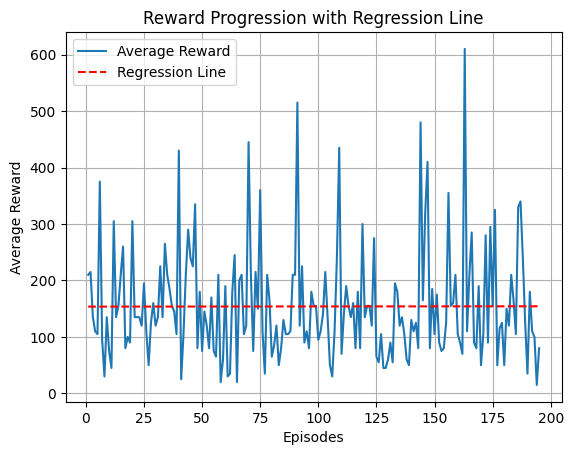

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Path to the log file
log_file_path = "./logs/training_log.txt"

# Lists to store parsed data
episodes = []
average_rewards = []

# Read and parse the log file
with open(log_file_path, "r") as log_file:
    # Skip the header line
    next(log_file)
    for line in log_file:
        data = line.strip().split(",")
        episodes.append(int(data[0]))
        average_rewards.append(float(data[1]))  # Reward is the second column

# Convert to numpy arrays
episodes_np = np.array(episodes)
average_rewards_np = np.array(average_rewards)

# Calculate the regression line
coefficients = np.polyfit(episodes_np, average_rewards_np, 1)  # Linear fit (degree=1)
regression_line = np.poly1d(coefficients)

# Plot the data and regression line
plt.plot(episodes_np, average_rewards_np, label="Average Reward")
plt.plot(episodes_np, regression_line(episodes_np), color="red", linestyle="--", label="Regression Line")
plt.xlabel("Episodes")
plt.ylabel("Average Reward")
plt.title("Reward Progression with Regression Line")
plt.legend()
plt.grid()
plt.show()